In [2]:
pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to /private/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/pip-req-build-c51ykw5f
  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git /private/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/pip-req-build-c51ykw5f
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymle-diffusion: filename=pymle_diffusion-0.0.4-py3-none-any.whl size=40920 sha256=6a90775bb9def2b728ff3bebf578adbd25358976ee1c0ecdab992518499e30ac
  Stored in directory: /private/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/pip-ephem-wheel-cache-9d95f8bg/wheels/0f/13/f6/83871fe3ee3c6831f6f8cc5989c9221b42b526ca31c5d0bf18
Successfully built pymle-diffusion

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, 

In [28]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st
import matplotlib.dates as mdates
from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [5]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [7]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

In [9]:
# your code
from pymle.data.loader import load_10yr_CMrate

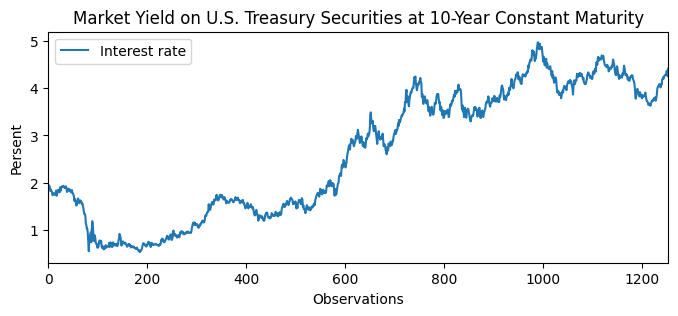

In [20]:
# Plot
figure, ax = plt.subplots(figsize=(8,3))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

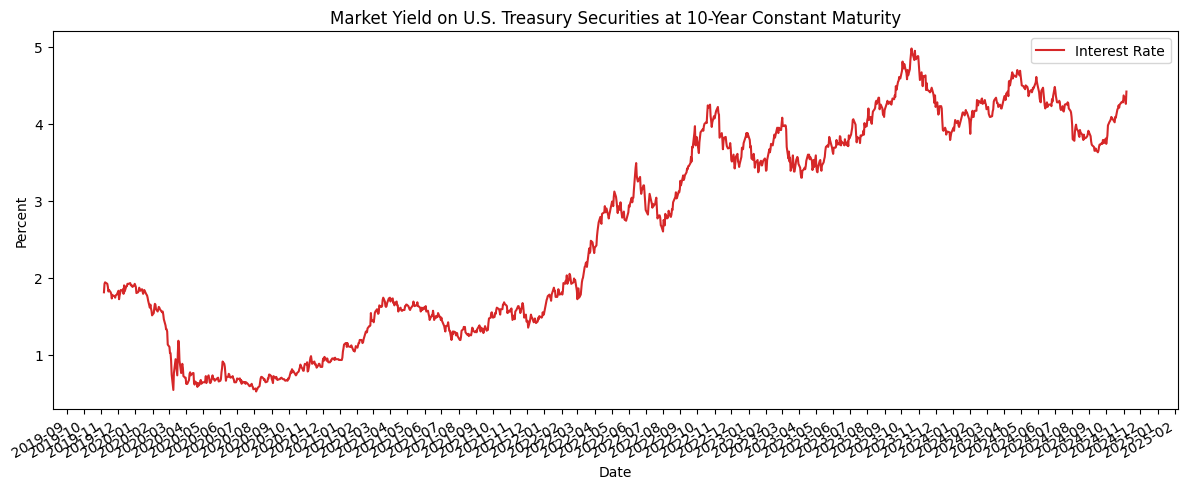

In [30]:
df_IR['DATE'] = pd.to_datetime(df_IR['DATE'], errors='coerce')
df_IR = df_IR.dropna(subset=['DATE'])

dates = df_IR['DATE']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, sample, label='Interest Rate', color='tab:red', linewidth=1.5)

#ax.xaxis.set_major_locator(mdates.YearLocator())  
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
fig.autofmt_xdate()

ax.set_title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
ax.set_xlabel('Date')
ax.set_ylabel('Percent')
ax.legend()
plt.tight_layout()
plt.show()

In [11]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [12]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 99, CG iterations: 50, optimality: 6.93e-04, constraint violation: 0.00e+00, execution time: 0.057 s.
Final Params: [0.52577211 0.99606105]
Final Likelihood: 1688.5031351385865
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 620, CG iterations: 411, optimality: 1.01e+01, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [0.04021861 0.41865339 0.7990315  0.24315419]
Final Likelihood: 1713.14808573056
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110449023
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 276, CG iterations: 88, optimality: 2.81e+00, constraint violation: 0.00e+00, execution time: 0.07 s.
Final Params: [0.03191792 0.97228134 0.6842959 ]
Final Likelihood: 1668.8177223246507
Initial Params: [0.01, 0.2]
Initial Likelihood: -952.570413375402
`xtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 30, CG iterations: 19, optimality: 2.24e+02, constraint violation: 0.00e+00, execution time: 0.011 s.
Final Params: [0.33961232 0.82111567]
Final Likelihood: 1245.9490235547728
Initial Params: [0.01, 

In [13]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -3373.006 - BrownianMotion model with params [0.52577211 0.99606105],
       -3418.296 - CEV model with params [0.04021861 0.41865339 0.7990315  0.24315419],
       -3331.635 - CIR model with params [0.03191792 0.97228134 0.6842959 ],
       -2487.898 - GeometricBM model with params [0.33961232 0.82111567],
       -2712.736 - IGBM model with params [0.71909431 2.60390359 0.59091266],
       -3371.151 - OrnsteinUhlenbeck model with params [0.12776936 6.72061882 0.9960037 ],
       -3420.939 - CKLS model with params [0.3913957  0.05389653 0.81633816 0.227809  ],
       
The best model is CKLS     with param [0.3913957  0.05389653 0.81633816 0.227809  ]


In [14]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 96, CG iterations: 58, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
Final Params: [0.52575747 0.99606106]
Final Likelihood: 1688.5031351392577
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.5899890722
`xtol` termination condition is satisfied.
Number of iterations: 177, function evaluations: 895, CG iterations: 418, optimality: 1.23e-02, constraint violation: 0.00e+00, execution time: 0.28 s.
Final Params: [0.1546211  5.59349201 0.81911933 0.22427329]
Final Likelihood: 1714.547549995581
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.38146138146
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 236, CG iterations: 131, optimality: 2.97e-02, constraint violation: 0.00e+00, execution time: 0.078 s.
Final Params: [0.13183693 6.4

In [15]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -3373.006 - BrownianMotion model with params [0.52575747 0.99606106],
       -3421.095 - CEV model with params [0.1546211  5.59349201 0.81911933 0.22427329],
       -3334.047 - CIR model with params [0.13183693 6.41890795 0.68439077],
       -2708.611 - GeometricBM model with params [0.33959551 0.59468609],
       -2710.932 - IGBM model with params [0.44295554 3.07002563 0.59458243],
       -3371.127 - OrnsteinUhlenbeck model with params [0.07423731 9.87632162 0.99615935],
       -3421.059 - CKLS model with params [0.53380145 0.01002347 0.81881469 0.22433496],
       
The best model is CEV     with param [0.1546211  5.59349201 0.81911933 0.22427329]


In [16]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 120, CG iterations: 59, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.054 s.
Final Params: [0.52575555 0.99606105]
Final Likelihood: 1688.5031351392681
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 85, function evaluations: 365, CG iterations: 199, optimality: 1.14e-05, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.08517519 8.74375967 0.81883613 0.22428031]
Final Likelihood: 1714.5748785815742
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.1718500081256
`gtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 220, CG iterations: 124, optimality: 3.02e-07, constraint violation: 0.00e+00, execution time: 0.075 s.
Final Params: [0.10663215

In [17]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -3373.006 - BrownianMotion model with params [0.52575555 0.99606105],
       -3421.150 - CEV model with params [0.08517519 8.74375967 0.81883613 0.22428031],
       -3334.053 - CIR model with params [0.10663215 7.54354313 0.68420268],
       -2708.614 - GeometricBM model with params [0.35406979 0.59508578],
       -2710.938 - IGBM model with params [0.41318322 3.24220985 0.59405827],
       -3371.151 - OrnsteinUhlenbeck model with params [0.12449787 6.83610016 0.99600334],
       -3421.059 - CKLS model with params [0.53384492 0.01000671 0.81883097 0.22433495],
       
The best model is CEV     with param [0.08517519 8.74375967 0.81883613 0.22428031]


In [18]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.04021861 0.41865339 0.7990315  0.24315419],
     [0.1546211  5.59349201 0.81911933 0.22427329],
     [0.08517519 8.74375967 0.81883613 0.22428031]


In [19]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [36]:
class ParameterEstimator:
    def __init__(self, data, models, names, bounds, guesses, dt=1/252):
        self.data = data
        self.models = models
        self.names = names
        self.bounds = bounds
        self.guesses = guesses
        self.dt = dt
        self.results = {method: {} for method in ['Kessler', 'Shoji-Ozaki', 'Euler']}

    def _run_estimation(self, method, model, bounds, guess):
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Метод {method} не поддерживается.")
        
        estimator = AnalyticalMLE(self.data, bounds, self.dt, density)
        results = estimator.estimate_params(guess)
        return results.aic, results.params

    def estimate_all(self):
        for method in self.results:
            for index, model in enumerate(self.models):
                aic_value, parameters = self._run_estimation(
                    method, model, self.bounds[index], self.guesses[index]
                )
                self.results[method][self.names[index]] = {'aic': aic_value, 'params': parameters}

    def display_aic(self):
        for method, models in self.results.items():
            print(f"\n{'='*50}")
            print(f"AIC для метода {method}:")
            print(f"{'Модель':<25} {'AIC':<10} {'Параметры'}")
            print("-" * 50)
            for name in self.names:
                model_data = models.get(name, {})
                print(f"{name:<25} {model_data.get('aic', 'N/A'):<10.3f} {model_data.get('params', 'N/A')}")
            print("="*50)

    def find_optimal_model(self):
        for method, models in self.results.items():
            optimal_model = min(models, key=lambda model: models[model]['aic'])
            optimal_params = models[optimal_model]['params']
            print(f"\n{'='*50}")
            print(f"Оптимальная модель для метода {method}: {optimal_model}")
            print(f"Параметры: {optimal_params}")
            print("="*50)

    def summarize_best_models(self):
        optimal_models = {
            method: min(self.results[method], key=lambda model: self.results[method][model]['aic'])
            for method in ['Kessler', 'Shoji-Ozaki', 'Euler']
        }

        print(f"\n{'='*50}")
        print("Сводка лучших моделей по методам:")
        print(f"{'Метод':<20} {'Лучшая модель':<25} {'Параметры'}")
        print("-" * 50)
        for method, model_name in optimal_models.items():
            parameters = self.results[method][model_name]['params']
            print(f"{method:<20} {model_name:<25} {parameters}")
        print("="*50)

In [37]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


estimator = ParameterEstimator(sample, model, model_name, param_bounds, param_guess)

estimator.estimate_all()
estimator.display_aic()
estimator.find_optimal_model()
estimator.summarize_best_models()

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 99, CG iterations: 50, optimality: 6.93e-04, constraint violation: 0.00e+00, execution time: 0.047 s.
Final Params: [0.52577211 0.99606105]
Final Likelihood: 1688.5031351385865
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 620, CG iterations: 411, optimality: 1.01e+01, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [0.04021861 0.41865339 0.7990315  0.24315419]
Final Likelihood: 1713.14808573056
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110449023
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 276, CG iterations: 88, optimality: 2.81e+00, constraint violation: 0.00e+00, execution time: 0.069 s.
Final Params: [0.03191792 0.

In [41]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [42]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

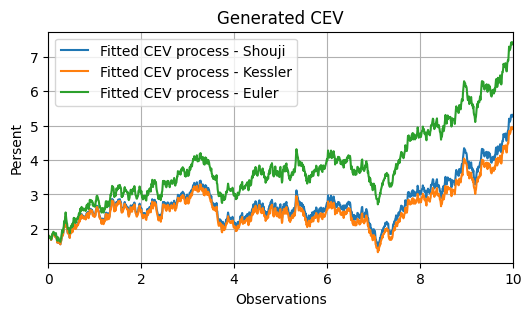

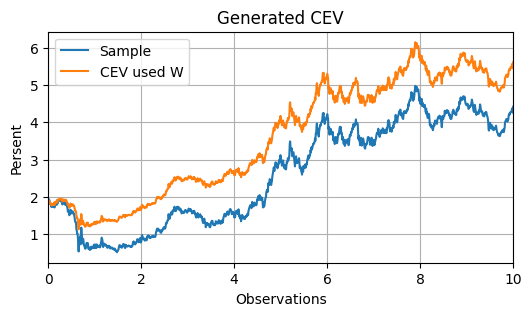

In [45]:
# Set data and generate the process:
T = 10
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

In [46]:
def CKLS_process(S, kappa, mu, sigma, gamma, dt, dW):
    S_non_neg = np.maximum(S, 1e-6)  
    dS = kappa * (mu - S) * dt + sigma * (S_non_neg**gamma) * dW
    return dS

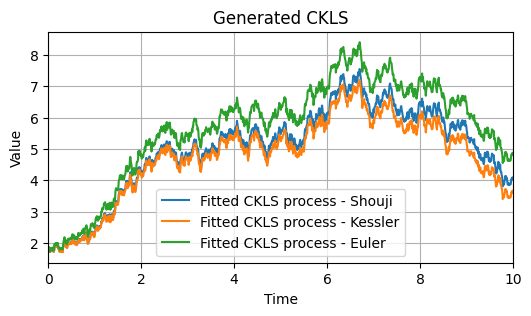

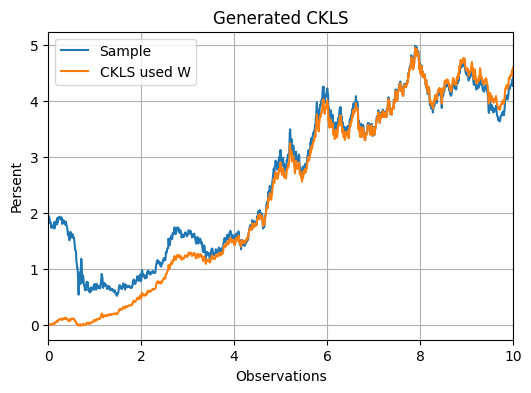

In [49]:
T = 10
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls0 = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + CKLS_process(ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + CKLS_process(ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + CKLS_process(ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    eckls[i] = eckls[i-1] + CKLS_process(eckls[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label="Fitted CKLS process - Shouji")
plt.plot(time_line, ckls_k, label="Fitted CKLS process - Kessler")
plt.plot(time_line, ckls_e, label="Fitted CKLS process - Euler")
plt.title("Generated CKLS")
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()


ax, figure = plt.subplots(figsize=(6, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label='CKLS used W')
plt.title("Generated CKLS")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [50]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 120, CG iterations: 59, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.06 s.
Final Params: [0.52575555 0.99606105]
Final Likelihood: 1688.5031351392681
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 85, function evaluations: 365, CG iterations: 199, optimality: 1.14e-05, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.08517519 8.74375967 0.81883613 0.22428031]
Final Likelihood: 1714.5748785815742
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.1718500081256
`gtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 220, CG iterations: 124, optimality: 3.02e-07, constraint violation: 0.00e+00, execution time: 0.077 s.
Final Params: [0.10663215 

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/pymle/core/TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


`xtol` termination condition is satisfied.
Number of iterations: 98, function evaluations: 440, CG iterations: 293, optimality: 1.31e-05, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.08979073 8.45221304 0.81766017 0.22522864]
Final Likelihood: 1714.5914808803186
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.3801253334877
`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 408, CG iterations: 200, optimality: 1.20e-04, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.19106916 5.36396796 0.68344224]
Final Likelihood: 1670.4365663818967
Initial Params: [0.01, 0.2]
Initial Likelihood: -955.5801685937931
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 75, CG iterations: 43, optimality: 3.79e-07, constraint violation: 0.00e+00, execution time: 0.036 s.
Final Params: [0.35381557 0.59466807]
Final Likelihood: 1356.3069592521128
Initial Params: [0.

100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

`gtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 260, CG iterations: 142, optimality: 1.94e-07, constraint violation: 0.00e+00, execution time: 0.089 s.
Final Params: [0.12449787 6.83610016 0.99600334]
Final Likelihood: 1688.5756297761573
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 230, CG iterations: 157, optimality: 4.08e-06, constraint violation: 0.00e+00, execution time: 0.069 s.
Final Params: [0.53384492 0.01000671 0.81883097 0.22433495]
Final Likelihood: 1714.5293833404521


Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [62]:
class ParametrEstimator:
    def __init__(self, sample, models, model_names, param_bounds, param_guesses, dt=1./252):
        self.sample = sample
        self.models = models
        self.model_names = model_names
        self.param_bounds = param_bounds
        self.param_guesses = param_guesses
        self.dt = dt
        self.results = {'Kessler': {}, 'Shoji-Ozaki': {}, 'Euler': {}}

    def estimate_params(self, method, model, param_bounds, param_guess):
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Unknown method {method}")
        
        estimator = AnalyticalMLE(self.sample, param_bounds, self.dt, density=density)
        result = estimator.estimate_params(param_guess)
        aic = result.aic
        bic = result.bic
        params = result.params
        return aic, bic, params

    def fit_models(self):
        for method in self.results.keys():
            for i, model in enumerate(self.models):
                aic, bic, params = self.estimate_params(method, model, self.param_bounds[i], self.param_guesses[i])
                self.results[method][self.model_names[i]] = {'aic': aic, 'bic': bic, 'params': params}

    def print_aic_bic_results(self):
        for method, data in self.results.items():
            print(f"\n{'='*40}")
            print(f"AIC and BIC values for {method} estimation:")
            print(f"{'Model':<20} {'AIC':<10} {'BIC':<10} {'Parameters'}")
            print("-" * 40)
            for model in self.model_names:
                aic = data[model]['aic']
                bic = data[model]['bic']
                params = data[model]['params']
                print(f"{model:<20} {aic:<10.3f} {bic:<10.3f} {params}")
            print("="*40)

    def print_best_model(self):
        for method, data in self.results.items():
            best_model_aic = min(data, key=lambda x: data[x]['aic'])
            best_model_bic = min(data, key=lambda x: data[x]['bic'])
            best_params_aic = data[best_model_aic]['params']
            best_params_bic = data[best_model_bic]['params']
            
            print(f"\n{'='*40}")
            print(f"Best models for {method} estimation:")
            print(f"AIC-based: {best_model_aic:<15} Parameters: {best_params_aic}")
            print(f"BIC-based: {best_model_bic:<15} Parameters: {best_params_bic}")
            print("="*40)

    def print_combined_results(self):
        best_models_aic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['aic'])
            for method in self.results
        }
        best_models_bic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['bic'])
            for method in self.results
        }
    
        print(f"\n{'='*40}")
        print("Combined Best Models Across All Methods (AIC and BIC):")
        print(f"{'Method':<15} {'AIC Best Model':<20} {'BIC Best Model':<20} {'Parameters (AIC)':<20} {'Parameters (BIC)'}")
        print("-" * 40)
        for method in self.results:
            best_model_aic = best_models_aic[method]
            best_model_bic = best_models_bic[method]
            best_params_aic = np.array2string(self.results[method][best_model_aic]['params'], precision=3)
            best_params_bic = np.array2string(self.results[method][best_model_bic]['params'], precision=3)
            print(f"{method:<15} {best_model_aic:<20} {best_model_bic:<20} {best_params_aic:<20} {best_params_bic}")
        print("="*40)

In [63]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]

estimator = ParametrEstimator(sample, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 99, CG iterations: 50, optimality: 6.93e-04, constraint violation: 0.00e+00, execution time: 0.052 s.
Final Params: [0.52577211 0.99606105]
Final Likelihood: 1688.5031351385865
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 620, CG iterations: 411, optimality: 1.01e+01, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [0.04021861 0.41865339 0.7990315  0.24315419]
Final Likelihood: 1713.14808573056
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110449023
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 276, CG iterations: 88, optimality: 2.81e+00, constraint violation: 0.00e+00, execution time: 0.069 s.
Final Params: [0.03191792 0.

In [ ]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [ ]:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [ ]:
# your code

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('DEXUSEU.csv')
data["DATE"] = pd.to_datetime(data["DATE"])
data["DEXUSEU"] = pd.to_numeric(data["DEXUSEU"], errors="coerce")
data.dropna(inplace=True)

# Параметры
dt = 1 / 252
exchange_rates = data["DEXUSEU"].values

# Функции для моделей и методов

# OU модель методом Эйлера
def ou_euler_method(data, dt):
    mu = np.mean(data)
    sigma = np.std(data)
    theta = 0.5
    predictions = [data[0]]
    for i in range(1, len(data)):
        dW = np.random.normal(0, np.sqrt(dt))
        X_next = predictions[-1] + theta * (mu - predictions[-1]) * dt + sigma * dW
        predictions.append(X_next)
    return predictions

# CEV модель методом Эйлера
def cev_euler_method(data, dt, beta=1.0):
    mu = np.mean(data)
    sigma = np.std(data)
    theta = 0.5
    predictions = [data[0]]
    for i in range(1, len(data)):
        dW = np.random.normal(0, np.sqrt(dt))
        X_next = predictions[-1] + theta * (mu - predictions[-1]) * dt + sigma * (predictions[-1] ** beta) * dW
        predictions.append(X_next)
    return predictions

# CIR модель методом Эйлера
def cir_euler_method(data, dt):
    mu = np.mean(data)
    sigma = np.std(data)
    theta = 0.5
    predictions = [data[0]]
    for i in range(1, len(data)):
        dW = np.random.normal(0, np.sqrt(dt))
        X_next = predictions[-1] + theta * (mu - predictions[-1]) * dt + sigma * np.sqrt(predictions[-1]) * dW
        predictions.append(max(X_next, 0))
    return predictions

# CKLS модель методом Эйлера
def ckls_euler_method(data, dt, gamma=1.5):
    mu = np.mean(data)
    sigma = np.std(data)
    theta = 0.5
    predictions = [data[0]]
    for i in range(1, len(data)):
        dW = np.random.normal(0, np.sqrt(dt))
        X_next = predictions[-1] + theta * (mu - predictions[-1]) * dt + sigma * (predictions[-1] ** gamma) * dW
        predictions.append(X_next)
    return predictions

# Метод Кесслера
def kessler_method(data, dt):
    mu = np.mean(data)
    sigma = np.std(data)
    theta = 0.5
    n = len(data)
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma**2) - np.sum((data[1:] - data[:-1] - theta * (mu - data[:-1]) * dt)**2) / (2 * sigma**2)
    return mu, sigma, theta, log_likelihood

# Метод Сёдзи-Озаки
def shoji_ozaki_method(data, dt):
    mu = np.mean(data)
    sigma = np.std(data)
    theta = 0.5
    n = len(data)
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma**2) - np.sum((data[1:] - data[:-1] - theta * (mu - data[:-1]) * dt)**2) / (2 * sigma**2)
    return mu, sigma, theta, log_likelihood

# Расчет AIC и BIC
def calculate_aic_bic(log_likelihood, num_params, n):
    aic = 2 * num_params - 2 * log_likelihood
    bic = np.log(n) * num_params - 2 * log_likelihood
    return aic, bic

# Прогнозы моделей
predicted_ou = ou_euler_method(exchange_rates, dt)
predicted_cev = cev_euler_method(exchange_rates, dt)
predicted_cir = cir_euler_method(exchange_rates, dt)
predicted_ckls = ckls_euler_method(exchange_rates, dt)

# Оценка методом Кесслера
mu_k, sigma_k, theta_k, log_likelihood_k = kessler_method(exchange_rates, dt)
aic_k, bic_k = calculate_aic_bic(log_likelihood_k, 3, len(exchange_rates))

# Оценка методом Сёдзи-Озаки
mu_cev, sigma_cev, theta_cev, log_likelihood_cev = shoji_ozaki_method(exchange_rates, dt)
mu_cir, sigma_cir, theta_cir, log_likelihood_cir = shoji_ozaki_method(exchange_rates, dt)
mu_ckls, sigma_ckls, theta_ckls, log_likelihood_ckls = shoji_ozaki_method(exchange_rates, dt)

aic_cev, bic_cev = calculate_aic_bic(log_likelihood_cev, 3, len(exchange_rates))
aic_cir, bic_cir = calculate_aic_bic(log_likelihood_cir, 3, len(exchange_rates))
aic_ckls, bic_ckls = calculate_aic_bic(log_likelihood_ckls, 3, len(exchange_rates))

# Результаты
results = pd.DataFrame({
    "Method": [
        "Kessler (OU Model)",
        "Shoji-Ozaki (CEV Model)",
        "Shoji-Ozaki (CIR Model)",
        "Shoji-Ozaki (CKLS Model)"
    ],
    "Log Likelihood": [
        log_likelihood_k,
        log_likelihood_cev,
        log_likelihood_cir,
        log_likelihood_ckls
    ],
    "AIC": [aic_k, aic_cev, aic_cir, aic_ckls],
    "BIC": [bic_k, bic_cev, bic_cir, bic_ckls]
})

# Вывод таблицы
print(results)

# Построение графиков
plt.figure(figsize=(14, 8))
plt.plot(data["DATE"], exchange_rates, label="Actual Data")
plt.plot(data["DATE"], predicted_ou, label="OU Model (Euler Method)", linestyle="--")
plt.plot(data["DATE"], predicted_cev, label="CEV Model (Euler Method)", linestyle="--")
plt.plot(data["DATE"], predicted_cir, label="CIR Model (Euler Method)", linestyle="--")
plt.plot(data["DATE"], predicted_ckls, label="CKLS Model (Euler Method)", linestyle="--")
plt.title("Comparison of Actual Data and Model Predictions")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid()
plt.show()


Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [ ]:
# your code

Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [ ]:
# your code